In [ ]:
import torch

torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("medium")

In [ ]:
import os

import numpy as np
import torch
from PIL import Image
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from torchvision.transforms import ToTensor

In [ ]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
device = None
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [ ]:
if device.type == "cuda":
    torch.cuda.empty_cache()

    torch.cuda.memory.set_per_process_memory_fraction(
        0.8
    )  # Optimisation recommandé par Nvidia

    # Afficher les informations sur le GPU
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(
        f"Mémoire totale: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB"
    )

GPU: NVIDIA RTX 4000 Ada Generation
Mémoire totale: 21.13 GB


In [6]:
from pathlib import Path


class StanfordDogsDataset(Dataset):
    def __init__(self, img_root, file_list, labels, transform=None):
        super().__init__()
        self.img_root = Path(img_root)
        self.file_list = file_list
        self.labels = labels
        self.transform = transform or ToTensor()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.img_root / self.file_list[index]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
train_mat = loadmat("/temp/data/train_list.mat")
test_mat = loadmat("/temp/data/test_list.mat")


train_list = [f[0][0] for f in train_mat["file_list"]]  # fichiers d'images
train_labels = [int(l[0]) - 1 for l in train_mat["labels"]]
test_list = [f[0][0] for f in test_mat["file_list"]]  # fichiers d'images
test_labels = [int(l[0]) - 1 for l in test_mat["labels"]]

train_tfms = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
test_tfms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

train_full_dataset = StanfordDogsDataset(
    img_root="/temp/data/Images",  # ou le chemin absolu vers le dossier Images/
    file_list=train_list,
    labels=train_labels,
    transform=train_tfms,
)

test_dataset = StanfordDogsDataset(
    img_root="/temp/data/Images",  # ou le chemin absolu vers le dossier Images/
    file_list=test_list,
    labels=test_labels,
    transform=test_tfms,
)

labels_np = np.array(train_labels)

train_indices, val_indices = train_test_split(
    list(range(len(train_list))), test_size=0.2, random_state=42, stratify=labels_np
)

val_dataset = StanfordDogsDataset(
    img_root="/temp/data/Images",
    file_list=[train_list[i] for i in val_indices],
    labels=[train_labels[i] for i in val_indices],
    transform=test_tfms,  # Utilisez les mêmes transformations que le test
)

train_dataset = Subset(train_full_dataset, train_indices)


num_workers = min(os.cpu_count(), 8)
batch_size = 32

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
)

print(
    f"Train : {len(train_dataset)} échantillons, Test : {len(test_dataset)} échantillons, split val : {len(val_dataset)}"
)

Train : 9600 échantillons, Test : 8580 échantillons, split val : 2400


In [ ]:
import torch.nn as nn
import torchvision.models as models

num_classes = 120


def build_model():
    model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model


# Utiliser le device détecté automatiquement
if device.type == "cuda":
    model = build_model().to(device, memory_format=torch.channels_last)
    # model = torch.compile(model, mode="reduce-overhead")  # PyTorch ≥ 2.1
else:
    model = build_model().to(device)
    # torch.compile n'est pas toujours compatible avec MPS/CPU
    if device.type == "cuda":
        model = torch.compile(model, mode="reduce-overhead")

In [9]:
def unfreeze_last_n_blocks_including_classifier(model, n):
    """
    Gèle tout puis dégèle les n derniers "blocs" en considérant model.features[...] puis
    model.classifier comme le dernier bloc.
      - n=1 => uniquement classifier dégelée
      - n=2 => features[-1] + classifier
      - ...
      - n=len(features)+1 => tout dégelé
    """
    blocks = list(model.features)
    has_classifier = hasattr(model, "classifier")
    sequence = blocks + ([model.classifier] if has_classifier else [])
    total = len(sequence)
    if n < 0:
        raise ValueError("n doit être >= 0")
    n = min(n, total)

    # Geler tout
    for block in sequence:
        for p in block.parameters():
            p.requires_grad = False

    # Dégeler les n derniers
    for block in sequence[-n:]:
        for p in block.parameters():
            p.requires_grad = True

    names = []
    for idx in range(total - n, total):
        if idx < len(blocks):
            names.append(f"features[{idx}]")
        else:
            names.append("classifier")
    print(f"[Optuna] Dégelé : {', '.join(names)}")

In [ ]:
def train(model, dataloader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device, non_blocking=True), labels.to(
            device, non_blocking=True
        )

        optimizer.zero_grad()
        with torch.autocast(
            device_type="cuda", dtype=torch.float16, enabled=device.type == "cuda"
        ):
            outputs = model(images)
            loss = criterion(outputs, labels)
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # if batch_idx % 10 == 0:
        # print(f"Batch {batch_idx}, Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [11]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device, non_blocking=True), labels.to(
                device, non_blocking=True
            )

            # Optimisation cuda
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [12]:
from torch.amp import GradScaler

scaler = GradScaler() if device.type == "cuda" else None

### Réduction de l'espace de recherche

In [ ]:
from random import seed

import optuna
import torch.optim as optim

from power_logger import PowerLogger

subset_train_value = (
    0.4  # Garde uniquement 40% de la valeur du train set pour accélerer l'étude Optuna
)
train_indices = train_dataset.indices
train_subset_labels = [train_labels[i] for i in train_indices]

# Stratification pour maintenir la distribution des classes
train_subset_indices, _ = train_test_split(
    range(len(train_dataset)),
    test_size=1 - subset_train_value,
    random_state=SEED,  # Fixe pour la reproductibilité
    stratify=train_subset_labels,
)

# Créer le subset final
train_subset = Subset(train_dataset, train_subset_indices)
print(
    f"Subset d'entraînement créé: {len(train_subset)} échantillons ({subset_train_value*100:.0f}% du dataset original)"
)

Subset d'entraînement créé: 3840 échantillons (40% du dataset original)


In [14]:
# Récupérer les indices réels des échantillons dans train_subset
train_subset_real_indices = [train_indices[i] for i in train_subset_indices]

# Vérifier le chevauchement avec val_indices
overlap = set(train_subset_real_indices).intersection(set(val_indices))

if len(overlap) > 0:
    print(f"ATTENTION: Chevauchement détecté! {len(overlap)} échantillons en commun.")
    print(f"Exemples d'indices en chevauchement: {list(overlap)[:5]}...")
else:
    print("Pas de chevauchement détecté entre train_subset et val_dataset.")

# Statistiques supplémentaires
print(f"Nombre d'échantillons dans train_subset: {len(train_subset_real_indices)}")
print(f"Nombre d'échantillons dans val_dataset: {len(val_indices)}")
print(
    f"Pourcentage de chevauchement: {len(overlap)/len(train_subset_real_indices)*100:.2f}%"
)

Pas de chevauchement détecté entre train_subset et val_dataset.
Nombre d'échantillons dans train_subset: 3840
Nombre d'échantillons dans val_dataset: 2400
Pourcentage de chevauchement: 0.00%


In [ ]:
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR


def objective(trial):
    if device.type == "cuda":
        torch.cuda.empty_cache()
    trial_model = build_model().to(device, memory_format=torch.channels_last)
    # --- hyperparamètres à chercher ---
    n_blocks = trial.suggest_int(
        "n_blocks", 1, len(trial_model.features) + 1
    )  # 1 = classifier seul
    lr_backbone = trial.suggest_float("lr_backbone", 1e-5, 1e-3, log=True)
    lr_classifier = trial.suggest_float("lr_classifier", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 192])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)

    # Application du dropout
    in_features = trial_model.classifier[1].in_features
    trial_model.classifier = nn.Sequential(
        nn.Dropout(dropout_rate), nn.Linear(in_features, num_classes)
    ).to(device)
    # Degels des couches
    unfreeze_last_n_blocks_including_classifier(trial_model, n_blocks)

    # Learning rate différencié backbone + classifier
    backbone_params = []
    classifier_params = []
    for name, param in trial_model.named_parameters():
        if not param.requires_grad:
            continue
        if "classifier" in name:
            classifier_params.append(param)
        else:
            backbone_params.append(param)

    param_groups = []
    if backbone_params:
        param_groups.append(
            {"params": backbone_params, "lr": lr_backbone, "weight_decay": weight_decay}
        )
    if classifier_params:
        param_groups.append(
            {
                "params": classifier_params,
                "lr": lr_classifier,
                "weight_decay": weight_decay,
            }
        )

    optimizer = optim.AdamW(param_groups)
    epsilon = 0.05
    criterion = nn.CrossEntropyLoss(label_smoothing=epsilon)
    g = torch.Generator()
    g.manual_seed(SEED)
    # --- loaders ---
    train_subset_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        generator=g,
        num_workers=8,  # num worker à 8 car 8 CPU disponible
        pin_memory=True,  # Optimisation pour GPU Nvidia
        persistent_workers=True,  # Optimisation GPU Nvidia
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
        persistent_workers=True,
    )
    num_epochs = 8
    warmup_epochs = 2
    scheduler = SequentialLR(
        optimizer,
        schedulers=[
            LinearLR(
                optimizer, start_factor=0.2, end_factor=1.0, total_iters=warmup_epochs
            ),  # warm-up
            CosineAnnealingLR(
                optimizer, T_max=num_epochs - warmup_epochs, eta_min=1e-6
            ),  # annealing
        ],
        milestones=[warmup_epochs],
    )

    logger = PowerLogger(interval=0.2, gpu_index=0)

    total_images = (len(train_subset) + len(val_dataset)) * num_epochs

    try:
        logger.start()

        for epoch in range(num_epochs):
            train_loss, train_acc = train(
                trial_model, train_subset_loader, criterion, optimizer, device, scaler
            )

            val_loss, val_acc = evaluate(trial_model, val_loader, criterion, device)
            print(
                f"[Optuna] val accuracy: {val_acc:.4f} - train accuracy: {train_acc:.4f}"
            )
            scheduler.step()

        energy_stats = logger.stop()
        total_energy = logger.get_energy_joules()
        energy_per_image = (
            total_energy / total_images if total_images > 0 else float("inf")
        )
    except Exception as e:
        logger.stop()
        print(f"Erreur pendant l'essai: {str(e)}")
        return 0.0, float("inf")

    return val_acc, energy_per_image

In [ ]:
population_size = 30
n_generation = 5
n_trials = population_size * n_generation
storage = "sqlite:////workspace/optuna_study.db"
sampler = optuna.samplers.NSGAIISampler(seed=SEED, population_size=population_size)
""" Enlever commentaire pour refaire la study, mettre load_if_exists à False et mettre un nouveau nom de study
study = optuna.create_study(
    directions=["maximize", "minimize"], sampler=sampler, storage=storage,study_name="M60HD-EXP", load_if_exists=True
)

study.optimize(objective, n_trials=n_trials)
"""

'\nstudy = optuna.create_study(\n    directions=["maximize", "minimize"], sampler=sampler, storage=storage,study_name="M60HD-EXP", load_if_exists=True\n)\n\nstudy.optimize(objective, n_trials=n_trials)\n'

In [ ]:
study = optuna.load_study(
    study_name="M60HD-EXP", storage="sqlite:///optuna_study.db"
)  # Chargement de l'étude (au lieu d'en refaire une nouvelle)

In [18]:
# Récupérer et afficher les meilleurs essais (front de Pareto)
pareto_front = study.best_trials

# Afficher les informations détaillées
print(f"Nombre de solutions sur le front de Pareto: {len(pareto_front)}")
for i, trial in enumerate(pareto_front):
    print(f"Solution {i+1}:")
    print(f"  Précision: {trial.values[0]:.2f}%")
    print(f"  Énergie/image: {trial.values[1]:.5f}J")
    print(f"  Paramètres: {trial.params}")
    print("---")

Nombre de solutions sur le front de Pareto: 12
Solution 1:
  Précision: 0.91%
  Énergie/image: 0.14506J
  Paramètres: {'n_blocks': 6, 'lr_backbone': 4.201672054372529e-05, 'lr_classifier': 0.001096821720752952, 'batch_size': 128, 'weight_decay': 0.005727904470799624, 'dropout': 0.4474136752138244}
---
Solution 2:
  Précision: 0.91%
  Énergie/image: 0.15682J
  Paramètres: {'n_blocks': 7, 'lr_backbone': 1.5679933916722995e-05, 'lr_classifier': 0.0023359635026261607, 'batch_size': 64, 'weight_decay': 0.004337920697490943, 'dropout': 0.11862454374840004}
---
Solution 3:
  Précision: 0.86%
  Énergie/image: 0.06445J
  Paramètres: {'n_blocks': 1, 'lr_backbone': 3.6296754488993606e-05, 'lr_classifier': 0.001096821720752952, 'batch_size': 64, 'weight_decay': 0.005727904470799624, 'dropout': 0.43155171293779676}
---
Solution 4:
  Précision: 0.92%
  Énergie/image: 0.16432J
  Paramètres: {'n_blocks': 8, 'lr_backbone': 5.252684100000481e-05, 'lr_classifier': 0.0025545577128619295, 'batch_size': 64,

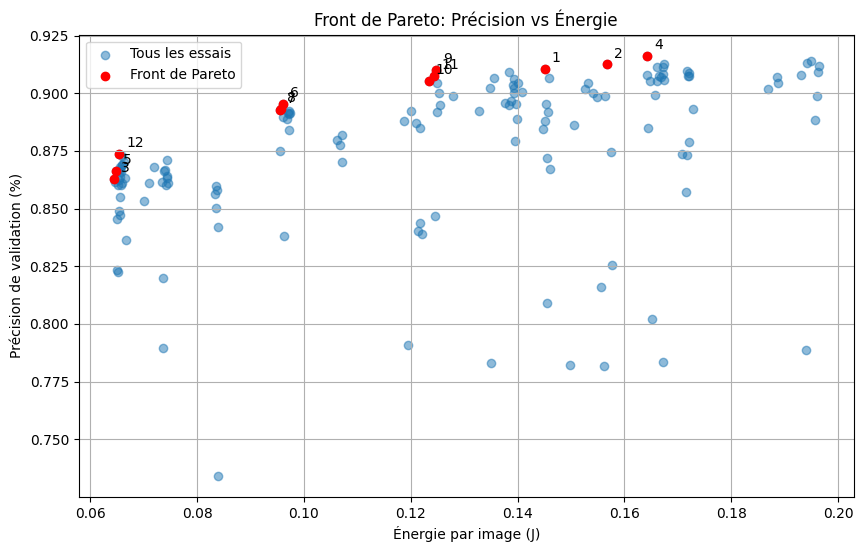

In [19]:
import matplotlib.pyplot as plt

# Extraire les valeurs pour tous les essais
accuracy_values = [trial.values[0] for trial in study.trials if trial.values[0] > 0]
energy_values = [trial.values[1] for trial in study.trials if trial.values[0] > 0]

# Extraire les valeurs pour le front de Pareto
pareto_accuracy = [trial.values[0] for trial in pareto_front]
pareto_energy = [trial.values[1] for trial in pareto_front]

plt.figure(figsize=(10, 6))
plt.scatter(energy_values, accuracy_values, alpha=0.5, label="Tous les essais")
plt.scatter(pareto_energy, pareto_accuracy, c="r", label="Front de Pareto")

# Ajouter des annotations pour les points du front de Pareto
for i, trial in enumerate(pareto_front):
    plt.annotate(
        f"{i+1}",
        (trial.values[1], trial.values[0]),
        xytext=(5, 5),
        textcoords="offset points",
    )

plt.xlabel("Énergie par image (J)")
plt.ylabel("Précision de validation (%)")
plt.title("Front de Pareto: Précision vs Énergie")
plt.legend()
plt.grid(True)
plt.savefig("pareto_front.png", dpi=300)
plt.show()

### Entrainement haute fidélité 1 - Efficacité maximale

In [ ]:
def evaluate_model_metrics(model, dataloader, device):
    """
    Évalue un modèle avec des métriques multiples: accuracy, top-3 accuracy et F1-score.

    Args:
        model: Le modèle à évaluer
        dataloader: Le dataloader contenant les données de test
        device: Le dispositif sur lequel exécuter l'évaluation (cpu, cuda, mps)

    Returns:
        tuple: (accuracy, top3_accuracy, f1_score) - Les métriques calculées
    """
    from sklearn.metrics import f1_score

    model.eval()
    all_preds = []
    all_labels = []
    correct_top1 = 0
    correct_top3 = 0
    total = 0

    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device, non_blocking=True), labels.to(
                device, non_blocking=True
            )

            # Utiliser autocast pour les GPU NVIDIA
            with torch.autocast(
                device_type="cuda", dtype=torch.float16, enabled=device.type == "cuda"
            ):
                outputs = model(images)

            # Top-1 accuracy
            _, predicted = torch.max(outputs.data, 1)
            correct_top1 += (predicted == labels).sum().item()

            # Top-3 accuracy
            _, top3_indices = outputs.topk(k=3, dim=1)
            batch_size = labels.size(0)

            # Vérifier si la vraie classe est dans le top-3 pour chaque échantillon
            for i in range(batch_size):
                if labels[i] in top3_indices[i]:
                    correct_top3 += 1

            # Stocker pour calculer le F1-score
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += batch_size

    # Calculer les métriques finales
    accuracy = correct_top1 / total
    top3_accuracy = correct_top3 / total

    # F1-score (moyenne macro sur toutes les classes)
    f1 = f1_score(all_labels, all_preds, average="macro")

    return accuracy, top3_accuracy, f1

In [ ]:
def train_model(config=None):
    """
    Entraîne un modèle avec les hyperparamètres spécifiés dans le dictionnaire config.

    Args:
        config (dict): Dictionnaire contenant les hyperparamètres:
            - batch_size: Taille des batchs
            - n_blocks: Nombre de blocs à dégeler (1 = classifier seul)
            - num_epochs: Nombre d'époques d'entraînement
            - lr_backbone: Learning rate pour le backbone
            - lr_classifier: Learning rate pour le classifier
            - weight_decay: Régularisation L2
            - dropout: Taux de dropout

    Returns:
        tuple: (model, test_acc, val_acc, train_acc) - Modèle entraîné et métriques
    """
    # Valeurs par défaut si non spécifiées
    if config is None:
        config = {}
    if len(config) == 0:
        raise ValueError("Dict empty")

    batch_size = config.get("batch_size")
    n_blocks = config.get("n_blocks")
    num_epochs = config.get("num_epochs")
    lr_backbone = config.get("lr_backbone")
    lr_classifier = config.get("lr_classifier")
    weight_decay = config.get("weight_decay")
    dropout_rate = config.get("dropout")

    if device.type == "cuda":
        torch.cuda.empty_cache()

    # Construction du modèle
    model = build_model().to(device, memory_format=torch.channels_last)
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(dropout_rate), nn.Linear(in_features, num_classes)
    ).to(device)

    # Dégeler les couches spécifiées
    unfreeze_last_n_blocks_including_classifier(model, n_blocks)

    g = torch.Generator()
    g.manual_seed(SEED)

    # Création du dataloader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        generator=g,
        num_workers=8,
        pin_memory=True,
        persistent_workers=True,
    )

    # Séparation des paramètres pour learning rate différencié
    backbone_params = []
    classifier_params = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if "classifier" in name:
            classifier_params.append(param)
        else:
            backbone_params.append(param)

    param_groups = []
    if backbone_params:
        param_groups.append(
            {"params": backbone_params, "lr": lr_backbone, "weight_decay": weight_decay}
        )
    if classifier_params:
        param_groups.append(
            {
                "params": classifier_params,
                "lr": lr_classifier,
                "weight_decay": weight_decay,
            }
        )

    optimizer = optim.AdamW(param_groups)
    criterion = nn.CrossEntropyLoss()

    # Configuration du scheduler
    warmup_epochs = 2
    scheduler = SequentialLR(
        optimizer,
        schedulers=[
            LinearLR(
                optimizer, start_factor=0.2, end_factor=1.0, total_iters=warmup_epochs
            ),
            CosineAnnealingLR(
                optimizer, T_max=num_epochs - warmup_epochs, eta_min=1e-6
            ),
        ],
        milestones=[warmup_epochs],
    )
    # logger
    logger = PowerLogger(interval=0.2, gpu_index=0)

    total_images = (len(train_dataset) + len(val_dataset)) * num_epochs
    # Entraînement
    train_acc_history = []
    val_acc_history = []

    try:
        logger.start()
        for epoch in range(num_epochs):
            train_loss, train_acc = train(
                model, train_loader, criterion, optimizer, device, scaler
            )

            val_loss, val_acc = evaluate(model, val_loader, criterion, device)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)

            print(
                f"Epoch {epoch+1}/{num_epochs} - Val accuracy: {val_acc:.4f} - Train accuracy: {train_acc:.4f}"
            )

            scheduler.step()

        energy_stats = logger.stop()
        total_energy = logger.get_energy_joules()

        energy_per_image = (
            total_energy / total_images if total_images > 0 else float("inf")
        )
    except Exception as e:
        print(f"Erreur pendant l'entraînement : {str(e)}")

    return model, val_acc_history, total_energy, energy_per_image

In [ ]:
import pandas as pd

config_efficient = {
    "n_blocks": 1,
    "lr_backbone": 3.6296754488993606e-05,
    "lr_classifier": 0.001096821720752952,
    "batch_size": 64,
    "weight_decay": 0.005727904470799624,
    "dropout": 0.431551712937796767,
    "num_epochs": 30,
}

model_efficient, val_accuracies, total_energy, e_per_img = train_model(config_efficient)

# Évaluation du modèle avec les métriques complètes
print("\nÉvaluation du modèle sur le jeu de test:")
test_acc, test_top3_acc, test_f1 = evaluate_model_metrics(
    model_efficient, test_loader, device
)

# Affichage détaillé des résultats
print("\nRésultats détaillés:")
print(f"Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Top-3 Accuracy: {test_top3_acc:.4f} ({test_top3_acc*100:.2f}%)")
print(f"F1-score (macro): {test_f1:.4f}")
print(f"total_energy {total_energy}")
print(f"Energy per image {e_per_img}")

df_results_efficiency = pd.DataFrame(
    {
        "model_id": "model_efficiency",
        "epoch": list(range(1, len(val_accuracies) + 1)),
        "val_accuracy": val_accuracies,
    }
)

print("Modèle entraîné et évalué avec succès!")

[Optuna] Dégelé : classifier
Epoch 1/30 - Val accuracy: 0.7667 - Train accuracy: 0.2700
Epoch 2/30 - Val accuracy: 0.8425 - Train accuracy: 0.6268


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 3/30 - Val accuracy: 0.8567 - Train accuracy: 0.6845
Epoch 4/30 - Val accuracy: 0.8675 - Train accuracy: 0.7064
Epoch 5/30 - Val accuracy: 0.8662 - Train accuracy: 0.7098
Epoch 6/30 - Val accuracy: 0.8662 - Train accuracy: 0.7200
Epoch 7/30 - Val accuracy: 0.8658 - Train accuracy: 0.7240
Epoch 8/30 - Val accuracy: 0.8742 - Train accuracy: 0.7293
Epoch 9/30 - Val accuracy: 0.8658 - Train accuracy: 0.7344
Epoch 10/30 - Val accuracy: 0.8696 - Train accuracy: 0.7427
Epoch 11/30 - Val accuracy: 0.8725 - Train accuracy: 0.7440
Epoch 12/30 - Val accuracy: 0.8738 - Train accuracy: 0.7378
Epoch 13/30 - Val accuracy: 0.8733 - Train accuracy: 0.7400
Epoch 14/30 - Val accuracy: 0.8696 - Train accuracy: 0.7457
Epoch 15/30 - Val accuracy: 0.8712 - Train accuracy: 0.7527
Epoch 16/30 - Val accuracy: 0.8662 - Train accuracy: 0.7407
Epoch 17/30 - Val accuracy: 0.8733 - Train accuracy: 0.7516
Epoch 18/30 - Val accuracy: 0.8758 - Train accuracy: 0.7561
Epoch 19/30 - Val accuracy: 0.8679 - Train accu

In [ ]:
config_knee = {
    "n_blocks": 4,
    "lr_backbone": 3.6464395589807184e-05,
    "lr_classifier": 0.0018742210985555703,
    "batch_size": 64,
    "weight_decay": 4.3805807679056575e-05,
    "dropout": 0.43155171293779676,
    "num_epochs": 30,
}

model_knee, val_accuracies, total_energy, e_per_img = train_model(config_knee)


df_results_knee = pd.DataFrame(
    {
        "model_id": "model_knee",
        "epoch": list(range(1, len(val_accuracies) + 1)),
        "val_accuracy": val_accuracies,
    }
)
# Évaluation du modèle avec les métriques complètes
print("\nÉvaluation du modèle sur le jeu de test:")
test_acc, test_top3_acc, test_f1 = evaluate_model_metrics(
    model_knee, test_loader, device
)

# Affichage détaillé des résultats
print("\nRésultats détaillés:")
print(f"Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Top-3 Accuracy: {test_top3_acc:.4f} ({test_top3_acc*100:.2f}%)")
print(f"F1-score (macro): {test_f1:.4f}")
print(f"total_energy {total_energy}")
print(f"Energy per image {e_per_img}")

[Optuna] Dégelé : features[5], features[6], features[7], classifier
Epoch 1/30 - Val accuracy: 0.8642 - Train accuracy: 0.4288
Epoch 2/30 - Val accuracy: 0.9004 - Train accuracy: 0.7381


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 3/30 - Val accuracy: 0.8996 - Train accuracy: 0.7744
Epoch 4/30 - Val accuracy: 0.9087 - Train accuracy: 0.7972
Epoch 5/30 - Val accuracy: 0.9004 - Train accuracy: 0.8252
Epoch 6/30 - Val accuracy: 0.9054 - Train accuracy: 0.8289
Epoch 7/30 - Val accuracy: 0.9100 - Train accuracy: 0.8429
Epoch 8/30 - Val accuracy: 0.9087 - Train accuracy: 0.8502
Epoch 9/30 - Val accuracy: 0.9129 - Train accuracy: 0.8565
Epoch 10/30 - Val accuracy: 0.9146 - Train accuracy: 0.8698
Epoch 11/30 - Val accuracy: 0.9150 - Train accuracy: 0.8778
Epoch 12/30 - Val accuracy: 0.9129 - Train accuracy: 0.8764
Epoch 13/30 - Val accuracy: 0.9133 - Train accuracy: 0.8783
Epoch 14/30 - Val accuracy: 0.9171 - Train accuracy: 0.8897
Epoch 15/30 - Val accuracy: 0.9137 - Train accuracy: 0.8947
Epoch 16/30 - Val accuracy: 0.9163 - Train accuracy: 0.8927
Epoch 17/30 - Val accuracy: 0.9142 - Train accuracy: 0.8935
Epoch 18/30 - Val accuracy: 0.9133 - Train accuracy: 0.9005
Epoch 19/30 - Val accuracy: 0.9129 - Train accu

In [ ]:
config_accuracy = {
    "n_blocks": 8,
    "lr_backbone": 5.252684100000481e-05,
    "lr_classifier": 0.0025545577128619295,
    "batch_size": 64,
    "weight_decay": 7.883068789768046e-05,
    "dropout": 0.40419867405823057,
    "num_epochs": 30,
}

model_accuracy, val_accuracies, total_energy, e_per_img = train_model(config_accuracy)


df_results_accuracy = pd.DataFrame(
    {
        "model_id": "model_accuracy",
        "epoch": list(range(1, len(val_accuracies) + 1)),
        "val_accuracy": val_accuracies,
    }
)
# Évaluation du modèle avec les métriques complètes
print("\nÉvaluation du modèle sur le jeu de test:")
test_acc, test_top3_acc, test_f1 = evaluate_model_metrics(
    model_accuracy, test_loader, device
)

# Affichage détaillé des résultats
print("\nRésultats détaillés:")
print(f"Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Top-3 Accuracy: {test_top3_acc:.4f} ({test_top3_acc*100:.2f}%)")
print(f"F1-score (macro): {test_f1:.4f}")
print(f"total_energy {total_energy}")
print(f"Energy per image {e_per_img}")

[Optuna] Dégelé : features[1], features[2], features[3], features[4], features[5], features[6], features[7], classifier
Epoch 1/30 - Val accuracy: 0.8875 - Train accuracy: 0.4938
Epoch 2/30 - Val accuracy: 0.9021 - Train accuracy: 0.7611


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 3/30 - Val accuracy: 0.8979 - Train accuracy: 0.7872
Epoch 4/30 - Val accuracy: 0.9054 - Train accuracy: 0.8148
Epoch 5/30 - Val accuracy: 0.8996 - Train accuracy: 0.8290
Epoch 6/30 - Val accuracy: 0.9075 - Train accuracy: 0.8396
Epoch 7/30 - Val accuracy: 0.8942 - Train accuracy: 0.8603
Epoch 8/30 - Val accuracy: 0.8988 - Train accuracy: 0.8611
Epoch 9/30 - Val accuracy: 0.8996 - Train accuracy: 0.8668
Epoch 10/30 - Val accuracy: 0.8954 - Train accuracy: 0.8795
Epoch 11/30 - Val accuracy: 0.8996 - Train accuracy: 0.8846
Epoch 12/30 - Val accuracy: 0.9000 - Train accuracy: 0.8915
Epoch 13/30 - Val accuracy: 0.9012 - Train accuracy: 0.8897
Epoch 14/30 - Val accuracy: 0.9096 - Train accuracy: 0.9008
Epoch 15/30 - Val accuracy: 0.9025 - Train accuracy: 0.9024
Epoch 16/30 - Val accuracy: 0.9058 - Train accuracy: 0.9024
Epoch 17/30 - Val accuracy: 0.9058 - Train accuracy: 0.9091
Epoch 18/30 - Val accuracy: 0.9042 - Train accuracy: 0.9131
Epoch 19/30 - Val accuracy: 0.9050 - Train accu

In [ ]:
df_all_results = pd.concat(
    [df_results_efficiency, df_results_knee, df_results_accuracy], ignore_index=True
)

In [27]:
df_all_results.to_csv("all_models_metrics.csv", index=False)